# Brains4Buildings interactive inverse grey-box analysis pipeline

This Jupyter Labs notebook can be used to interactively test the Brains4Buildings inverse grey-box analysis pipeline, accessing data from a Twomes database (see also [more information how to setup a Twomes server](https://github.com/energietransitie/twomes-backoffice-configuration#jupyterlab)).
Don't forget to install the requirements listed in [requirements.txt](../requirements.txt) first!



## Setting the stage

First several imports and variables need to be defined


### Imports and generic settings

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget


from tqdm.notebook import tqdm

from gekko import GEKKO

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

%load_ext autoreload

from virtualdata import Virtualdata 
from inversegreyboxmodel import Learner

# usually, two decimals suffice for displaying DataFrames (NB internally, precision may be higher)
pd.options.display.precision = 2

### Load Data from Virtual Rooms

In [2]:
%%time

rooms = [
    100010045, 
    100020045, 
    100020180, 
    500010045, 
    500010090 
]

timezone = 'Europe/Amsterdam'
df_data_rooms = pd.DataFrame()

for room_id in tqdm(rooms):
    df_data_rooms = pd.concat(
        [df_data_rooms,
         Virtualdata.get_virtual_room_data_csv(f'../data/virtualroom_P{room_id}.zip', timezone)
        ]
    )

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 298 ms, sys: 38.3 ms, total: 337 ms
Wall time: 332 ms


In [3]:
df_data_rooms

occupancy_p  co2_ppm  valve_frac_0
room_id   timestamp                                                    
100010045 2022-01-03 00:00:00+01:00            0      415           0.0
          2022-01-03 00:15:00+01:00            0      415           0.0
          2022-01-03 00:30:00+01:00            0      415           0.0
          2022-01-03 00:45:00+01:00            0      415           0.0
          2022-01-03 01:00:00+01:00            0      415           0.0
...                                          ...      ...           ...
500010090 2022-01-23 22:45:00+01:00            0      423           0.0
          2022-01-23 23:00:00+01:00            0      423           0.0
          2022-01-23 23:15:00+01:00            0      423           0.0
          2022-01-23 23:30:00+01:00            0      422           0.0
          2022-01-23 23:45:00+01:00            0      422           0.0

[10080 rows x 3 columns]

## Learn parameters using inverse grey-box analysis

Most of the heavy lifting is done by the `learn_room_parameter()` function, which again uses the [GEKKO Python](https://machinelearning.byu.edu/) dynamic optimization toolkit.

In [4]:
%%time 
%autoreload 2

# learn the model parameters and write results to a dataframe

df_results, df_data_rooms = Learner.learn_room_parameter(df_data_rooms, ev_type=2)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 184 ms, sys: 26.8 ms, total: 211 ms
Wall time: 18.2 s


### Result Visualization

In [5]:
df_results

,duration_s,OBJFCNVAL,EV_TYPE,vent_min_m3_h_1,vent_max_m3_h_1,room_true_m3,infilt_true_cm2,infilt_cm2,mae_ppm,rmse_ppm
room_id,,,,,,,,,,
100010045,1.81e+06,2.13e+08,2,10.0,100.0,45.0,9.26,8.04,49.76,69.35
100020045,1.81e+06,3.00e+08,2,20.0,100.0,45.0,18.52,10.91,65.62,82.28
100020180,1.81e+06,7.03e+07,2,20.0,100.0,180.0,18.52,14.14,32.97,39.82
500010045,1.81e+06,1.96e+08,2,10.0,500.0,45.0,9.26,8.32,46.20,66.49
500010090,1.81e+06,9.18e+07,2,10.0,500.0,90.0,9.26,9.07,31.95,45.49


In [6]:
df_data_rooms

occupancy_p  co2_ppm  valve_frac_0  \
room_id   timestamp                                                       
100010045 2022-01-03 00:00:00+01:00            0      415           0.0   
          2022-01-03 00:15:00+01:00            0      415           0.0   
          2022-01-03 00:30:00+01:00            0      415           0.0   
          2022-01-03 00:45:00+01:00            0      415           0.0   
          2022-01-03 01:00:00+01:00            0      415           0.0   
...                                          ...      ...           ...   
500010090 2022-01-23 22:45:00+01:00            0      423           0.0   
          2022-01-23 23:00:00+01:00            0      423           0.0   
          2022-01-23 23:15:00+01:00            0      423           0.0   
          2022-01-23 23:30:00+01:00            0      422           0.0   
          2022-01-23 23:45:00+01:00            0      422           0.0   

                                    co2_sim_ppm  
room_id   timestamp                              
100010045 2022-01-03 00:00:00+01:00       415.0  
          2022-01-03 00:15:00+01:00       415.0  
          2022-01-03 00:30:00+01:00       415.0  
          2022-01-03 00:45:00+01:00       415.0  
          2022-01-03 01:00:00+01:00       415.0  
...                                         ...  
500010090 2022-01-23 22:45:00+01:00      424.59  
          2022-01-23 23:00:00+01:00      424.34  
          2022-01-23 23:15:00+01:00      424.09  
          2022-01-23 23:30:00+01:00      423.85  
          2022-01-23 23:45:00+01:00      423.62  

[10080 rows x 4 columns]

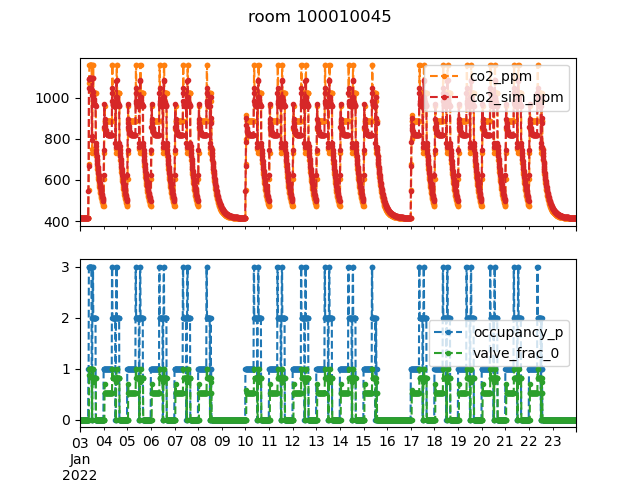

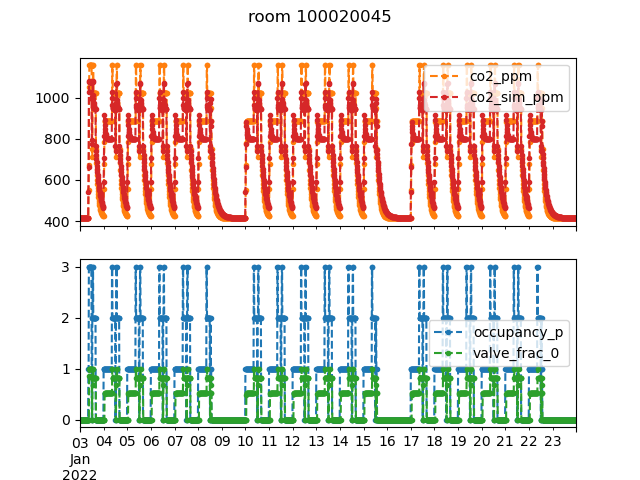

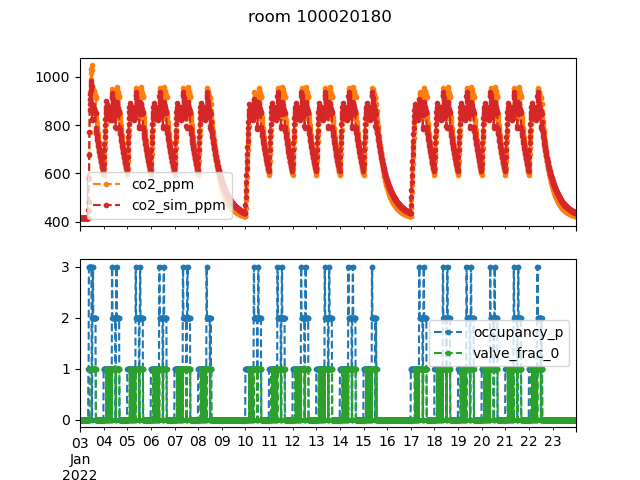

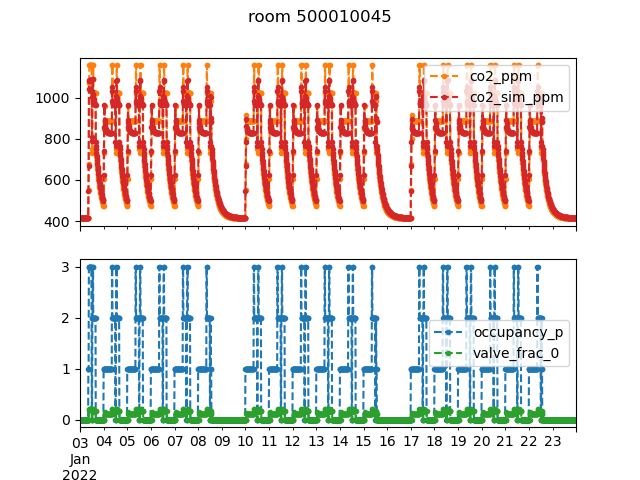

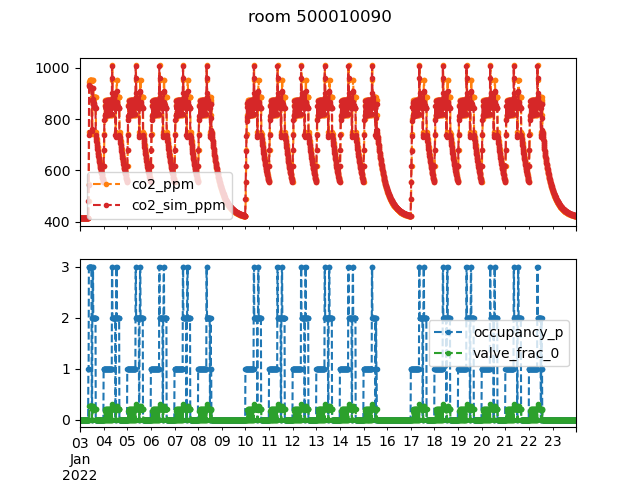

In [7]:
for room_id in rooms:
        df_data_rooms.loc[room_id].plot(subplots=[('co2_ppm', 'co2_sim_ppm'), 
                                                  ('valve_frac_0', 'occupancy_p')
                                                 ],
                                        style='.--',
                                        title=f'room {room_id}'
                                       )